In [1]:
import pandas as pd
import seaborn as sns
import pyBigWig
import pyranges as pr
import genomicranges as gr
from matplotlib import pyplot as plt
import glob 

sns.set_context("talk")

chr_categories = [str(i) for i in list(range(1,23))]
chr_categories.extend(["X", "Y"])
chr_categories = ["chr"+i for i in chr_categories]

GENOME_LENGHT = pr.data.chromsizes().End.sum()

In [2]:
def merge_intervals(intervals):
    # Sort the intervals by their starting point
    sorted_intervals = sorted(intervals, key=lambda x: x[0])

    # Initialize the merged interval list with the first interval
    merged_intervals = [sorted_intervals[0]]

    # Iterate over the sorted intervals, merging overlapping intervals
    for interval in sorted_intervals[1:]:
        last_merged = merged_intervals[-1]

        # If the current interval overlaps with the last merged interval, merge them
        if interval[0] <= last_merged[1]:
            merged_intervals[-1] = (last_merged[0], max(last_merged[1], interval[1]))
        else:
            merged_intervals.append(interval)

    # Calculate the total length of the merged intervals
    total_length = sum(end - start for start, end in merged_intervals)

    return merged_intervals, total_length

## Check how much of the region is covered with binary

In [3]:
### Collect stats 
n_peaks = pd.DataFrame()
chromosome = "chr1"

def get_chr_stats(chromosome, bbb):
    len_chr = bbb.chroms()[chromosome]
    peaks = bbb.entries(chromosome, 0,len_chr,withString=False )

    # Create peak ranges object
    peaks_ranges = pd.DataFrame(peaks)
    peaks_ranges.columns = ["start", "end"]
    peaks_ranges["len"] = peaks_ranges.start - peaks_ranges.end
    # Stats 
    merged_intervals, total_length = merge_intervals(peaks)


    # Create Summary DF
    entry = pd.DataFrame([{"chr": chromosome, "n_peaks": len(peaks), "len": len_chr, "covered_len": total_length}])
    entry["perc_covered"] = (entry.covered_len * 100) / entry.len
    bed_stats = pd.concat([n_peaks,entry],ignore_index=True)
    return(bed_stats)

def get_bed_stats(bbb): 
    bed_stats = pd.DataFrame()
    for chromosome in set(bbb.chroms().keys()): 
            bed_stats = pd.concat([bed_stats, get_chr_stats(chromosome, bbb)])
    return(bed_stats)

def prep_bed_stats_chrom(bb):
    bbb = pyBigWig.open(bb)
    tissue = bb.split("/")[-2]
    filename = bb.split("/")[-1]
    bed_stats = get_bed_stats(bbb)
    bed_stats["chr"] = pd.Categorical(bed_stats["chr"], chr_categories)
    bed_stats = bed_stats.sort_values(by = "chr")
    bed_stats["tissue"] = tissue
    bed_stats["filename"] = filename
    return(bed_stats)

In [4]:
def pool_bed_stats(bb):
    bbb = pyBigWig.open(bb)
    tissue = bb.split("/")[-2]
    filename = bb.split("/")[-1]
    bed_stats = get_bed_stats_pooled(bbb)
    bed_stats["tissue"] = tissue
    bed_stats["filename"] = filename
    return(bed_stats)

## Which is the coverage of the genome?
### Across tissues? 

In [5]:
import pyranges as pr
files = glob.glob("/home/luisasantus/Desktop/crg_cluster/data/FED/out/downloads/Homo sapiens/ATAC-seq/*/*.bed")

In [13]:
def get_bed_pooled_coverage(bed): 
    tissue = bed.split("/")[-2]
    filename = bed.split("/")[-1]
    covered =  pr.read_bed(bed).merge(strand=False).length
    entry = pd.DataFrame([{"tissue": tissue, "filename": filename, "covered": covered, "perc_covered": covered*100/GENOME_LENGHT}])
    return(entry)

In [14]:
summary_beds_coverage = pd.concat(list(map(get_bed_pooled_coverage,files)), ignore_index= True)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
sns.displot(summary_beds_coverage, x = "perc_covered" )

### And what if we group all of them? 

In [15]:
collapsed_atac = "/home/luisasantus/Desktop/crg_cluster/data/FED/out/downloads/Homo sapiens/ATAC-seq/collapsed/ATAC-seq.bed"

In [16]:
get_bed_pooled_coverage(collapsed_atac)

,tissue,filename,covered,perc_covered
0,collapsed,ATAC-seq.bed,283811469,9.167943


## Paralogs analysis

In [18]:
list_ids = "/home/luisasantus/Desktop/crg_cluster/data/FED/gene_lists/dgd_Hsa_all_v71.genes"
id_df = pd.read_csv(list_ids, sep = "\t", header = None)
ids = list(id_df[0])

test_genes = "/home/luisasantus/Desktop/crg_cluster/data/FED/gene_lists/dgd_Hsa_all_v71.tsv"
gene_groups = pd.read_csv(test_genes, sep = "\t")
#gene_pairs = gene_groups[gene_groups.NB_Genes > 2]

In [24]:
# We are working now with the pooled one
enrichment_result =  "/home/luisasantus/Desktop/crg_cluster/data/FED/out/enrichment/dgd_Hsa_all_v71_ENCFF012SCX_0.50_overlap_binary.txt"
enrichment = pd.read_csv(enrichment_result, sep = "\t", header = None)
enrichment.columns = ["ENS_ID", "track_binary"]

In [25]:
# Here I can have different comparison functions
def comparison_binary_equality(df):
    column_index = df.columns.get_loc("track_binary")
    a = df.to_numpy() 
    return(a[0] == a).all(0)[column_index]

def get_distance(df):
    end_index = df.columns.get_loc("end")
    start_index = df.columns.get_loc("start")
    max_end = max(df["end"])
    min_end = min(df["start"])
    return max_end - min_end

In [5]:
# Add enrichment tracks to 

In [26]:
gene_pairs_enriched = gene_groups.merge(enrichment, on = "ENS_ID")

In [27]:
group_track_comparison = pd.DataFrame(gene_pairs_enriched.groupby(["group_id"]).apply(comparison_binary_equality)).reset_index()
group_track_comparison = group_track_comparison.rename(columns= {0:"track_binary_eval"})
gene_pairs_eval = gene_pairs_enriched.merge(group_track_comparison, on = "group_id" )

In [47]:
# Check how many were called open 
summary_genes_ocr = gene_pairs_eval.track_binary.value_counts()

In [53]:
pd.DataFrame(summary_genes_ocr).rename(index = { 0 : "closed", 1: "open"}, columns = {"track_binary": "paralog genes"})

,paralog genes
closed,3451
open,46


# Check the distances across paralogs 

In [41]:
group_distance = pd.DataFrame(gene_pairs_enriched.groupby(["group_id"]).apply(get_distance)).reset_index()
group_distance = group_distance.rename(columns= {0:"distance"})
gene_pairs_eval_distance = gene_pairs_eval.merge(group_distance, on = "group_id" )
chr_count = gene_pairs_eval_distance.groupby("group_id")["chr"].count()

In [33]:
gene_pairs_eval_distance.track_binary.value_counts()

0    3451
1      46
Name: track_binary, dtype: int64

In [43]:
gene_pairs_eval_distance

,chr,group_id,NB_Genes,start,end,strand,ENS_ID,Name,Description,track_binary,track_binary_eval,distance
0,1,1,3,1385069,1405538,1,ENSG00000215915,ATAD3C,"ATPase family, AAA domain containing 3C [Sourc...",0,True,84998
1,1,1,3,1407143,1433228,1,ENSG00000160072,ATAD3B,"ATPase family, AAA domain containing 3B [Sourc...",0,True,84998
2,1,1,3,1447531,1470067,1,ENSG00000197785,ATAD3A,"ATPase family, AAA domain containing 3A [Sourc...",0,True,84998
3,1,2,2,1570603,1590473,-1,ENSG00000248333,CDK11B,cyclin-dependent kinase 11B [Source:HGNC Symbo...,0,True,85163
4,1,2,2,1634169,1655766,-1,ENSG00000008128,CDK11A,cyclin-dependent kinase 11A [Source:HGNC Symbo...,0,True,85163
...,...,...,...,...,...,...,...,...,...,...,...,...
3492,Y,1010,4,25365594,25437503,1,ENSG00000205944,DAZ2,deleted in azoospermia 2 [Source:HGNC Symbol;A...,0,True,1777681
3493,Y,1010,4,26909216,26959626,-1,ENSG00000187191,DAZ3,deleted in azoospermia 3 [Source:HGNC Symbol;A...,0,True,1777681
3494,Y,1010,4,26980008,27053183,1,ENSG00000205916,DAZ4,deleted in azoospermia 4 [Source:HGNC Symbol;A...,0,True,1777681
3495,Y,1011,2,26191376,26194166,-1,ENSG00000172352,CDY1B,"chromodomain protein, Y-linked, 1B [Source:HGN...",0,True,1579673


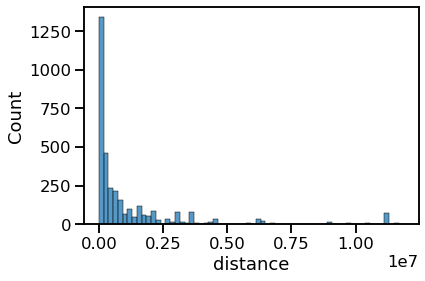

In [44]:
sns.set_context("talk")
a = sns.histplot(data= gene_pairs_eval_distance, x = "distance") 